# Hiera encoder + FPN decoder

Want a simple starter encoder + decoder architecture


In [1]:
import torch
import torch.nn.functional as F
from enum import Enum

from torchvision.io import read_image
from torchvision import transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

import matplotlib.pyplot as plt
import numpy as np

from hiera import hiera_base_224, Hiera

device='cuda'
dtype=torch.float32

%load_ext autoreload
%autoreload 2

In [2]:
torch.cuda.is_available()

True

In [3]:
# sample tensors used throughout notebook

x = torch.rand(1, 3, 224, 224).to(device)
y = torch.rand(1, 3, 512, 512).to(device)
w = torch.rand((1, 3, 256, 256)).to(device)

## Loading pretrained model from hiera docs

In [4]:
from hiera_utils import pretrained_model

In [5]:
checkpoints = {
    "example_checkpoint": "https://dl.fbaipublicfiles.com/hiera/hiera_base_224.pth"
}

@pretrained_model(checkpoints, default="example_checkpoint")
def create_hiera_model():
    return Hiera(input_size=(256,256), num_classes=10)

In [6]:
model4 = create_hiera_model().to(device)

## Note on unroll func

Find unroll code in hiera_utils

N = 13456 = 464 * 29 (which is patch_size = 16 * 29 = 464) which will be divided by 4
N// 4 = 3364 which sqrt = 58

This doesn't work because we are unrolling the thing several times

Eventaully we do 29 // 2 which loses values for us

Design choice, scale up even further to 512

In [7]:
intermediates = model4(w, return_intermediates=True)

In [8]:
# intermedaites is a list of checkpoints after each downscale by 2 and embed_dim *2
for i in intermediates:
    print(i.shape)

torch.Size([1, 64, 64, 96])
torch.Size([1, 32, 32, 192])
torch.Size([1, 16, 16, 384])
torch.Size([1, 8, 8, 768])


## Prepare sample data

Random images taken from online human segmentation dataset 
Masks arent' very good

https://github.com/VikramShenoy97/Human-Segmentation-Dataset/blob/master/Training_Images/107.jpg

In [107]:
img = read_image('assets/107.jpg')
mask = read_image('assets/107.png')

In [108]:
transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
test_transform = transforms.Resize((256,256))

In [109]:
sample = transform(img.to(dtype)) / 255.
mask = test_transform(mask.to(dtype))

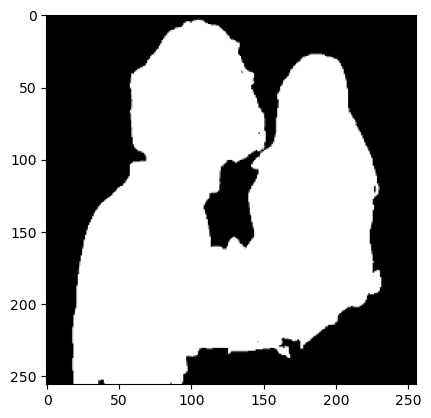

In [110]:
plt.imshow(mask.permute(1, 2, 0), cmap='gray')

In [111]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
def imgnet_vis(img, grad=True):
    # if uses grad, detach
    if grad:
        image = img.squeeze(0).permute(1, 2, 0).detach()
    else:
        image = img.squeeze(0).permute(1, 2, 0)
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.axis('off')
    return

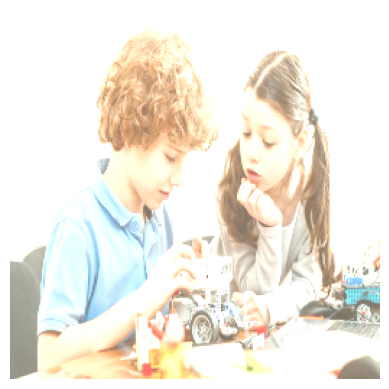

In [112]:
imgnet_vis(sample)

In [113]:
sample = sample.to(device)
mask = mask.to(device)
# add batch
sample = sample.unsqueeze(0)
mask = mask.unsqueeze(0)
sample.shape

torch.Size([1, 3, 256, 256])

In [114]:
intermediates = model4(sample, return_intermediates=True)

In [115]:
for i in intermediates:
    print(i.shape)

torch.Size([1, 64, 64, 96])
torch.Size([1, 32, 32, 192])
torch.Size([1, 16, 16, 384])
torch.Size([1, 8, 8, 768])


## Attach Segmentation head

Simple FPN segmentation head from AOT

https://github.com/yoxu515/aot-benchmark/blob/main/networks/decoders/fpn.py

In [18]:
from decoder import FPNSegmentationHead

In [19]:
# input dim is last from shortcuts, shortcut dims from intermeidates
head = FPNSegmentationHead(768, 1, decode_intermediate_input=False, shortcut_dims=[96,192,384,768]).to(device)

In [20]:
# expecting b, c, h, w shape
shortcuts = []
for i in intermediates:
    shortcuts.append(i.permute(0, 3, 1, 2))

In [21]:
out = head([shortcuts[-1]], shortcuts)

In [22]:
out.shape

torch.Size([1, 1, 64, 64])

In [23]:
# decode to full size, can also absorb this into the seg head
output_size = [256, 256]
pred_id_logits = torch.nn.functional.interpolate(out,
                               size=output_size,
                               mode="bilinear",
                               align_corners=True)

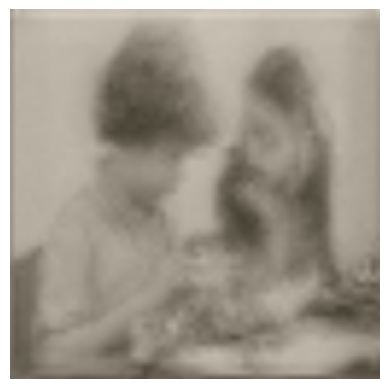

In [24]:
imgnet_vis(pred_id_logits.cpu())

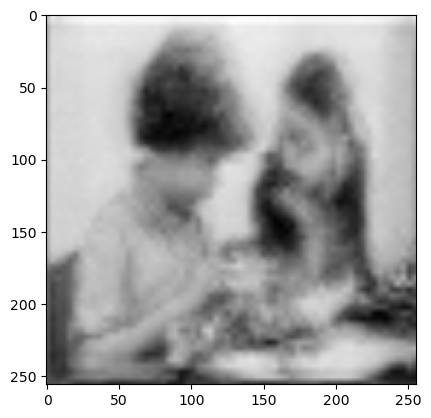

In [25]:
with torch.no_grad():
    pred = torch.sigmoid(pred_id_logits)
    pred_mask = pred.squeeze().cpu().numpy()
    plt.imshow(pred_mask, cmap='gray')
    plt.show()

In [180]:
## Collection of losses

def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

def dice_loss(probas, labels, smooth=1):

    C = probas.size(1)
    losses = []
    for c in list(range(C)):
        fg = (labels == c).float()
        if fg.sum() == 0:
            continue
        class_pred = probas[:, c]
        p0 = class_pred
        g0 = fg
        numerator = 2 * torch.sum(p0 * g0) + smooth
        denominator = torch.sum(p0) + torch.sum(g0) + smooth
        losses.append(1 - ((numerator) / (denominator)))
    return mean(losses)

def flatten_probas(probas, labels, ignore=255):
    """
    Flattens predictions in the batch
    """
    B, C, H, W = probas.size()
    probas = probas.permute(0, 2, 3,
                            1).contiguous().view(-1, C)  # B * H * W, C = P, C
    labels = labels.view(-1)
    if ignore is None:
        return probas, labels
    valid = (labels != ignore)
    vprobas = probas[valid.view(-1, 1).expand(-1, C)].reshape(-1, C)
    # vprobas = probas[torch.nonzero(valid).squeeze()]
    vlabels = labels[valid]
    return vprobas, vlabels

def tversky_loss(probas, labels, alpha=0.5, beta=0.5, epsilon=1e-6):
    '''
    Tversky loss function.
        probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
        labels: [P] Tensor, ground truth labels (between 0 and C - 1)

    Same as soft dice loss when alpha=beta=0.5.
    Same as Jaccord loss when alpha=beta=1.0.
    See `Tversky loss function for image segmentation using 3D fully convolutional deep networks`
    https://arxiv.org/pdf/1706.05721.pdf
    '''
    C = probas.size(1)
    losses = []
    for c in list(range(C)):
        fg = (labels == c).float()
        if fg.sum() == 0:
            continue
        class_pred = probas[:, c]
        p0 = class_pred
        p1 = 1 - class_pred
        g0 = fg
        g1 = 1 - fg
        numerator = torch.sum(p0 * g0)
        denominator = numerator + alpha * \
            torch.sum(p0*g1) + beta*torch.sum(p1*g0)
        losses.append(1 - ((numerator) / (denominator + epsilon)))
    return mean(losses)


SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch

def iou_loss(preds, targets, smooth=1e-8):
    """
    Calculate Intersection over Union (IoU) loss

    Arguments:
    preds -- tensor of model predictions (before sigmoid activation function if used with BCEWithLogitsLoss)
    targets -- tensor of target values, same shape as preds
    smooth -- smoothing factor to prevent division by zero

    Returns:
    IoU loss as a single float tensor
    """
    # Apply sigmoid to preds to get the binary mask, if your model doesn't include a final sigmoid activation
    # preds = torch.sigmoid(preds)

    # Calculate intersection and union
    intersection = (preds * targets).sum(dim=(2, 3))  # Sum over height and width dimensions
    total = (preds + targets).sum(dim=(2, 3))
    union = intersection - total

     # Calculate IoU and IoU loss
    iou = (intersection + smooth) / (union + smooth)
    loss = 1 - iou # Subtracting from 1 to make it a loss (higher is worse)

    # Average over the batch
    return loss.mean()

def jaccord_loss(pred, label, ignore_index=True):
    pred = F.softmax(pred, dim=1)
    label = label.view(1, 1, pred.size()[2], pred.size()[3])
    loss = tversky_loss(*flatten_probas(pred, label, ignore=ignore_index),alpha=1.0,beta=1.0)
    return loss

In [181]:
iou_loss(torch.tensor(np.zeros((256, 256))).to('cuda'), mask)

tensor(1.0000, device='cuda:0', dtype=torch.float64)

In [204]:
# loss_fn = dice_loss
# loss_fn = iou_loss
# loss_fn = jaccord_loss
loss_fn = torch.nn.BCEWithLogitsLoss()

## Condense model into single module

In [205]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = create_hiera_model()
        self.decoder = FPNSegmentationHead(768, 1, decode_intermediate_input=False, shortcut_dims=[96,192,384,768])
        
    def forward(self, x):
        intermediates = self.encoder(x, return_intermediates=True)
        shortcuts = []
        for i in intermediates:
            shortcuts.append(i.permute(0, 3, 1, 2))
        x = self.decoder([shortcuts[-1]], shortcuts)
        return x

In [206]:
m = Model().to(device)
sum(p.numel() for p in m.parameters())

52247435

In [207]:
optim = torch.optim.Adam(m.parameters(), lr=0.001)

In [208]:
# repeat training for number of steps
output_size = [256, 256]

for _ in range(100):
    optim.zero_grad()
    out = m(sample) # output is mask of shape 64x64, so we interpolate it to 256x256
    pred_id_logits = torch.nn.functional.interpolate(out,
                                   size=output_size,
                                   mode="bilinear",
                                   align_corners=True)
    loss = loss_fn(pred_id_logits, mask)
    print(loss.item())
    loss.backward()
    optim.step()

-178.0896453857422
-730.6070556640625
-990.7902221679688
-1079.514404296875
-1128.0096435546875
-1164.569580078125
-1202.771240234375
-1238.4891357421875
-1294.3203125
-1358.751953125
-1417.215576171875
-1452.08984375
-510.29248046875
-1439.443115234375
-1456.541748046875
-1431.0087890625
-1419.31103515625
-1419.1824951171875
-1425.85693359375
-1436.55517578125
-1450.20166015625
-1466.341796875
-1485.0152587890625
-1506.6475830078125
-1532.08203125
-1562.3531494140625
-1598.34521484375
-1640.4798583984375
-1689.1236572265625
-1742.587158203125
-1785.091064453125
-1807.9200439453125
-1828.7381591796875
-1855.786865234375
-1884.519287109375
-1909.6728515625
-1932.545654296875
-1956.8455810546875
-1984.876708984375
-2016.5546875
-2049.189453125
-2080.911376953125
-2114.5048828125
-2154.642578125
-2198.484619140625
-2243.679931640625
-2294.90869140625
-2330.15380859375
-2353.35205078125
-2358.794921875
-2397.46630859375
-2439.307373046875
-2476.8896484375
-2499.6513671875
-2520.38232421875

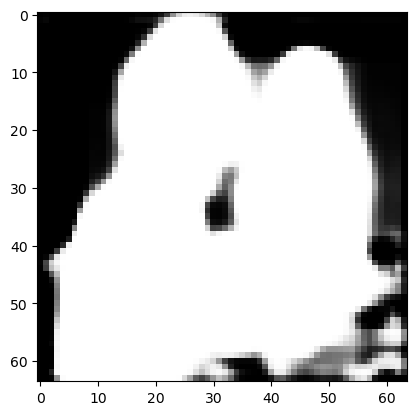

In [210]:
with torch.no_grad():
    m.eval()
    pred = torch.sigmoid(m(sample))
    pred_mask = pred.squeeze().cpu().numpy()
    plt.imshow(pred_mask, cmap='gray')
    plt.show()

## Note: this extreme divergence isn't good, shouldn't be negative either

In [211]:
iou_pytorch(pred_id_logits.to(torch.int), mask.to(torch.int))

tensor([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.,